In [13]:
import numpy as np

from hepinfo.models.MiVAE import MiVAE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from functools import partial

import mplhep
mplhep.style.use('CMS')

In [14]:
# read in the data
normal_data = np.load("../data/normal_data.npy", allow_pickle=True)
abnormal_data = np.load("../data/abnormal_data.npy", allow_pickle=True)

In [15]:
# perform some pre-processing and split into train test
nPV = normal_data[:,0]
nPV_abnormal = abnormal_data[:,0]
X = normal_data[:,1:]
abnormal_data = abnormal_data[:,1:]

X_train, X_test, nPV_train, nPV_test = train_test_split(X, nPV, shuffle=True)
abnormal_data_train, abnormal_data_test, nPV_abnormal_train, nPV_abnormal_test = train_test_split(abnormal_data, nPV_abnormal, shuffle=True)

y_train = np.concatenate((np.ones(len(abnormal_data_train)), np.zeros(len(X_train))))
y_test = np.concatenate((np.ones(len(abnormal_data_test)), np.zeros(len(X_test))))

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
abnormal_data_train_scaled = scaler.transform(abnormal_data_train)
abnormal_data_test_scaled = scaler.transform(abnormal_data_test)

In [17]:
def custom_scorer(estimator, X, y, abnormal_data_train_scaled):
    kl_loss = estimator.score_vector(X)[1]
    mean_loss = estimator.get_mean(X).numpy()
    sigma_loss = estimator.get_sigma(X).numpy()

    kl_loss_abnorm = estimator.score_vector(abnormal_data_train_scaled)[1]
    mean_loss_abnorm = estimator.get_mean(abnormal_data_train_scaled).numpy()
    sigma_loss_abnorm = estimator.get_sigma(abnormal_data_train_scaled).numpy()

    X = np.column_stack((kl_loss, mean_loss, sigma_loss))
    X_abnorm = np.column_stack((kl_loss_abnorm, mean_loss_abnorm, sigma_loss_abnorm))
    X_total = np.concatenate((X_abnorm, X))
    X_total = np.nan_to_num(X_total)
    y = np.concatenate((np.ones(len(abnormal_data_train_scaled)), np.zeros(len(X))))

    X_train, X_test, y_train, y_test = train_test_split(X_total, y, shuffle=True, stratify=y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    reg = linear_model.LogisticRegression()
    reg.fit(X_train, y_train)
    auc = roc_auc_score(y_test, reg.predict_proba(X_test)[:,1])

    return auc

scorer = partial(custom_scorer, abnormal_data_train_scaled=abnormal_data_train_scaled)

param_grid = {
    'hidden_layers': [[32, 16], [64, 32]],  # Different network architectures
    'activation': ['relu', 'tanh', 'sigmoid'],  # Different activation functions
    'latent_dims': [4, 8, 16],  # Latent space dimensions
    'drop_out': [0.0, 0.2, 0.4],  # Dropout rates
    'beta_param': [1, 10, 100],  # Weight for KL loss
    'gamma': [1, 10, 100],
    'batch_size': [32, 64, 128, 256],  # Batch sizes
    'learning_rate': [0.0001, 0.00001],  # Learning rates
    'optimizer': ['Adam'],  # Different optimizers
    'epoch': [10, 50, 100],  # Number of epochs
}

MiVAE_model = MiVAE(verbose=0, run_eagerly=False, epoch=100, batch_size=256, latent_dims=8, drop_out=0)

grid_search = RandomizedSearchCV(
    MiVAE_model,
    param_grid,
    cv=3,
    n_jobs=1,
    n_iter=10,
    verbose=3,
    scoring=scorer
)
grid_search.fit(X_train, nPV_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END activation=sigmoid, batch_size=32, beta_param=10, drop_out=0.2, epoch=50, gamma=1, hidden_layers=[32, 16], latent_dims=8, learning_rate=1e-05, optimizer=Adam;, score=0.757 total time= 3.4min
[CV 2/3] END activation=sigmoid, batch_size=32, beta_param=10, drop_out=0.2, epoch=50, gamma=1, hidden_layers=[32, 16], latent_dims=8, learning_rate=1e-05, optimizer=Adam;, score=0.729 total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END activation=sigmoid, batch_size=32, beta_param=10, drop_out=0.2, epoch=50, gamma=1, hidden_layers=[32, 16], latent_dims=8, learning_rate=1e-05, optimizer=Adam;, score=0.703 total time= 3.4min
[CV 1/3] END activation=relu, batch_size=64, beta_param=1, drop_out=0.2, epoch=10, gamma=1, hidden_layers=[32, 16], latent_dims=16, learning_rate=1e-05, optimizer=Adam;, score=0.650 total time=  27.8s
[CV 2/3] END activation=relu, batch_size=64, beta_param=1, drop_out=0.2, epoch=10, gamma=1, hidden_layers=[32, 16], latent_dims=16, learning_rate=1e-05, optimizer=Adam;, score=0.654 total time=  28.3s
[CV 3/3] END activation=relu, batch_size=64, beta_param=1, drop_out=0.2, epoch=10, gamma=1, hidden_layers=[32, 16], latent_dims=16, learning_rate=1e-05, optimizer=Adam;, score=0.653 total time=  27.7s
[CV 1/3] END activation=relu, batch_size=256, beta_param=10, drop_out=0.4, epoch=100, gamma=10, hidden_layers=[32, 16], latent_dims=16, learning_rate=0.0001, optimizer=Adam;, score=0.601 total 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END activation=sigmoid, batch_size=128, beta_param=1, drop_out=0.4, epoch=100, gamma=10, hidden_layers=[64, 32], latent_dims=16, learning_rate=0.0001, optimizer=Adam;, score=0.792 total time= 2.7min
[CV 3/3] END activation=sigmoid, batch_size=128, beta_param=1, drop_out=0.4, epoch=100, gamma=10, hidden_layers=[64, 32], latent_dims=16, learning_rate=0.0001, optimizer=Adam;, score=0.809 total time= 2.7min


KeyboardInterrupt: 

In [ ]:
# train the model
MiVAE_model = MiVAE(
    verbose=2,
    activation="sigmoid",
    batch_size=128,
    beta_param=1,
    drop_out=0.4,
    epoch=100,
    gamma=10,
    hidden_layers=[64, 32],
    latent_dims=16,
    learning_rate=0.0001,
    optimizer="Adam",
    run_eagerly=False
)
history = MiVAE_model.fit(X_train, nPV_train)

MiVAE_model_gamma_zero = MiVAE(
    verbose=2,
    activation="sigmoid",
    batch_size=128,
    beta_param=1,
    drop_out=0.4,
    epoch=100,
    gamma=0,
    hidden_layers=[64, 32],
    latent_dims=16,
    learning_rate=0.0001,
    optimizer="Adam",
    run_eagerly=False
)
history_gamma_zero = MiVAE_model_gamma_zero.fit(X_train, nPV_train)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_116     │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_290 (Dense)   │ (None, 64)        │      3,712 │ input_layer_116[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_160         │ (None, 64)        │          0 │ dense_290[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_291 (Dense)   │ (None, 32)        │      2,080 │ dropout_160[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_161         │ (None, 32)        │          0 │ dense_291[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        528 │ dropout_161[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        528 │ dropout_161[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_58         │ (None, 16)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,848 (26.75 KB)

 Trainable params: 6,848 (26.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_117 (InputLayer)    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 57)             │         3,705 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,361 (24.85 KB)

 Trainable params: 6,361 (24.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1172/1172 - 4s - 3ms/step - kl_loss: 0.2820 - loss: 0.2848 - mi_loss: 2.7641e-04 - reconstruction_loss: 0.1058
Epoch 2/100
1172/1172 - 2s - 2ms/step - kl_loss: 4.9113e-04 - loss: 0.0024 - mi_loss: 1.9339e-04 - reconstruction_loss: 0.1057
Epoch 3/100
1172/1172 - 2s - 2ms/step - kl_loss: 3.5322e-04 - loss: 0.0019 - mi_loss: 1.5582e-04 - reconstruction_loss: 0.1058
Epoch 4/100
1172/1172 - 2s - 2ms/step - kl_loss: 2.9313e-04 - loss: 0.0015 - mi_loss: 1.2442e-04 - reconstruction_loss: 0.1058
Epoch 5/100
1172/1172 - 2s - 2ms/step - kl_loss: 2.4042e-04 - loss: 0.0012 - mi_loss: 9.9498e-05 - reconstruction_loss: 0.1058
Epoch 6/100
1172/1172 - 3s - 2ms/step - kl_loss: 1.9625e-04 - loss: 9.4312e-04 - mi_loss: 7.4687e-05 - reconstruction_loss: 0.1057
Epoch 7/100
1172/1172 - 3s - 2ms/step - kl_loss: 1.5955e-04 - loss: 7.5039e-04 - mi_loss: 5.9083e-05 - reconstruction_loss: 0.1058
Epoch 8/100
1172/1172 - 3s - 2ms/step - kl_loss: 1.2968e-04 - loss: 5.6124e-04 - mi_loss: 4.3156e-05 - reco

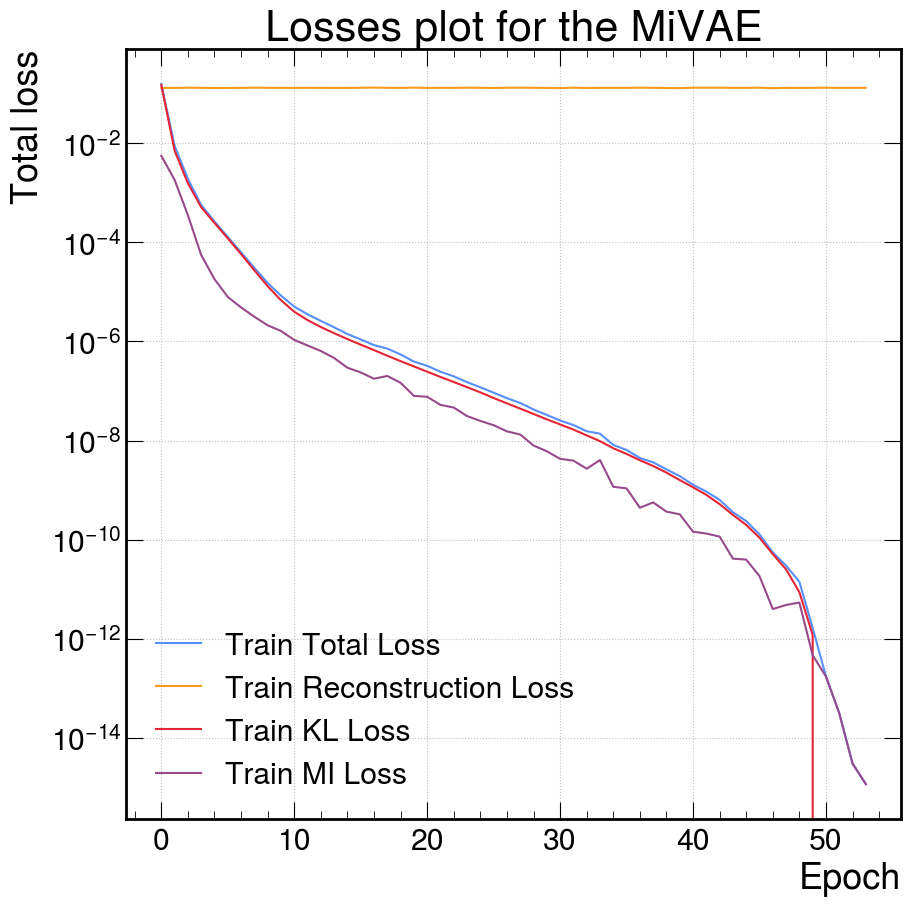

In [ ]:
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Train Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='Train KL Loss')
plt.plot(history.history['mi_loss'], label='Train MI Loss')
plt.yscale("log")
plt.ylabel("Total loss")
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.grid()

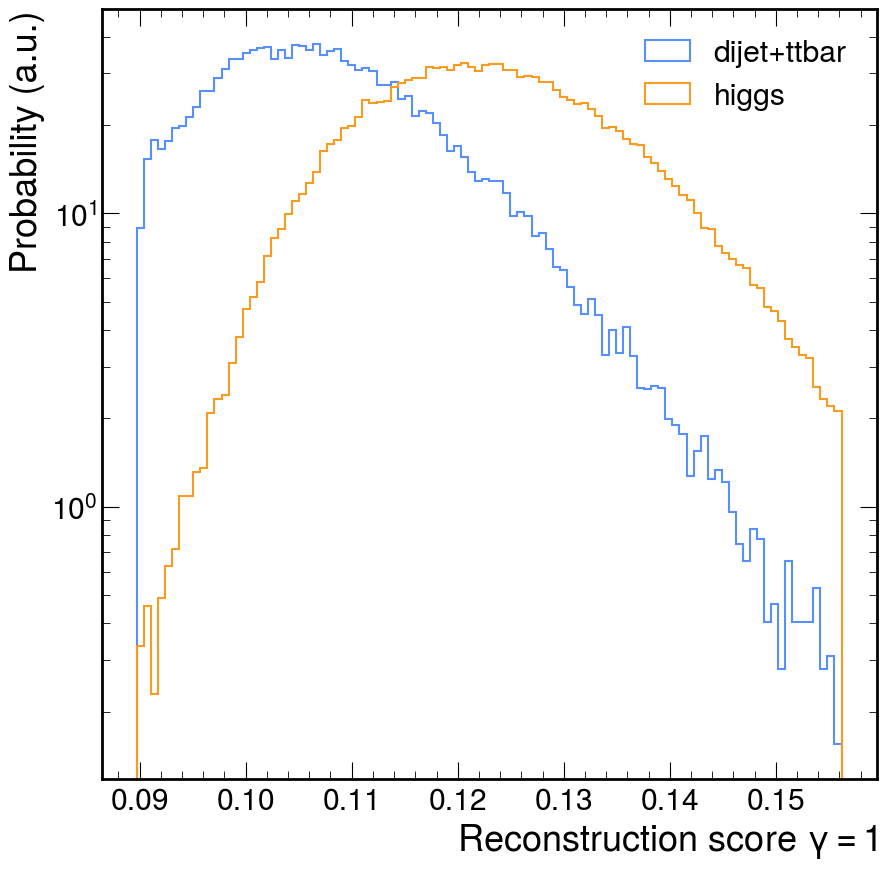

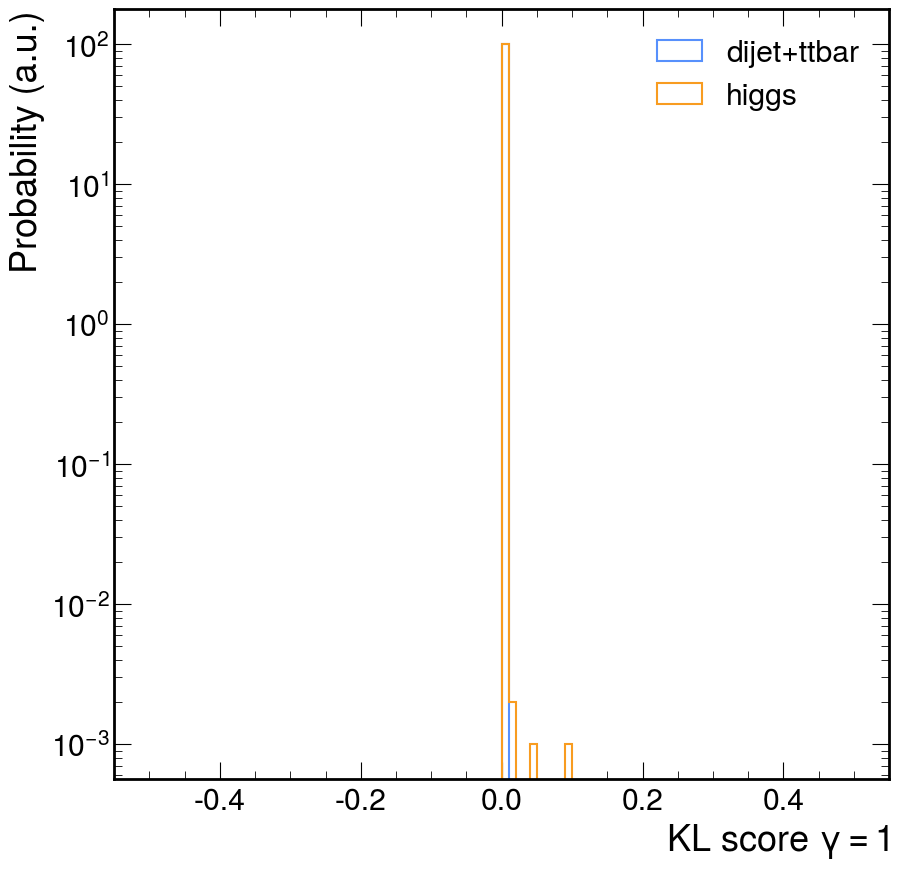

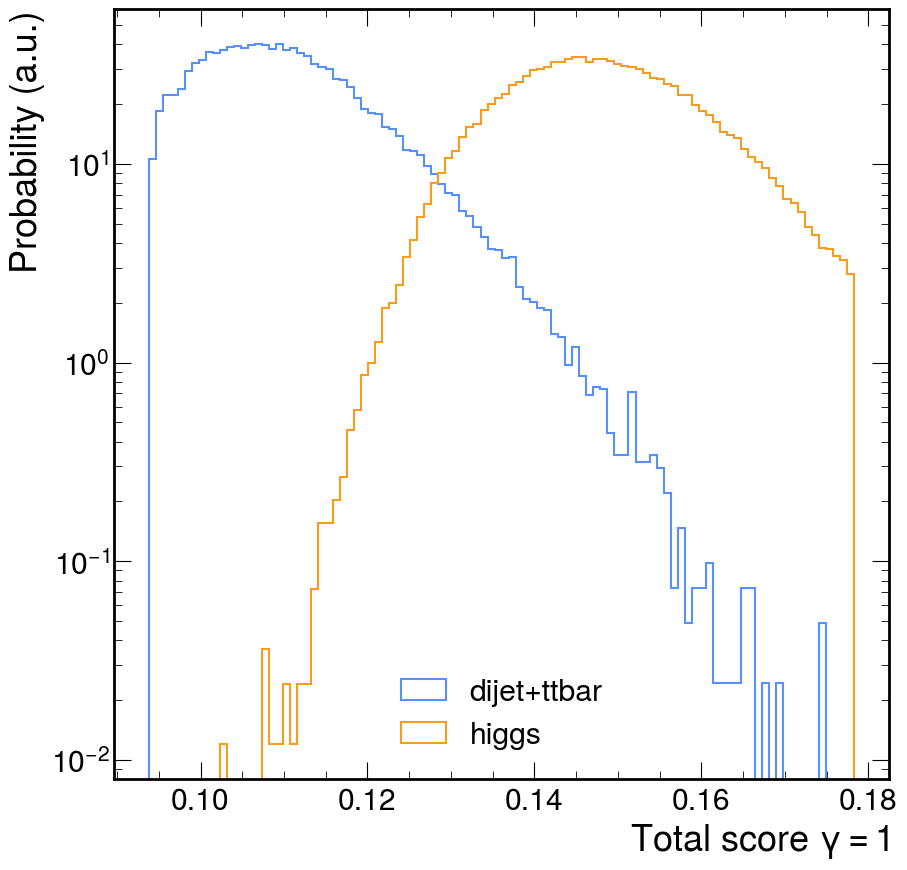

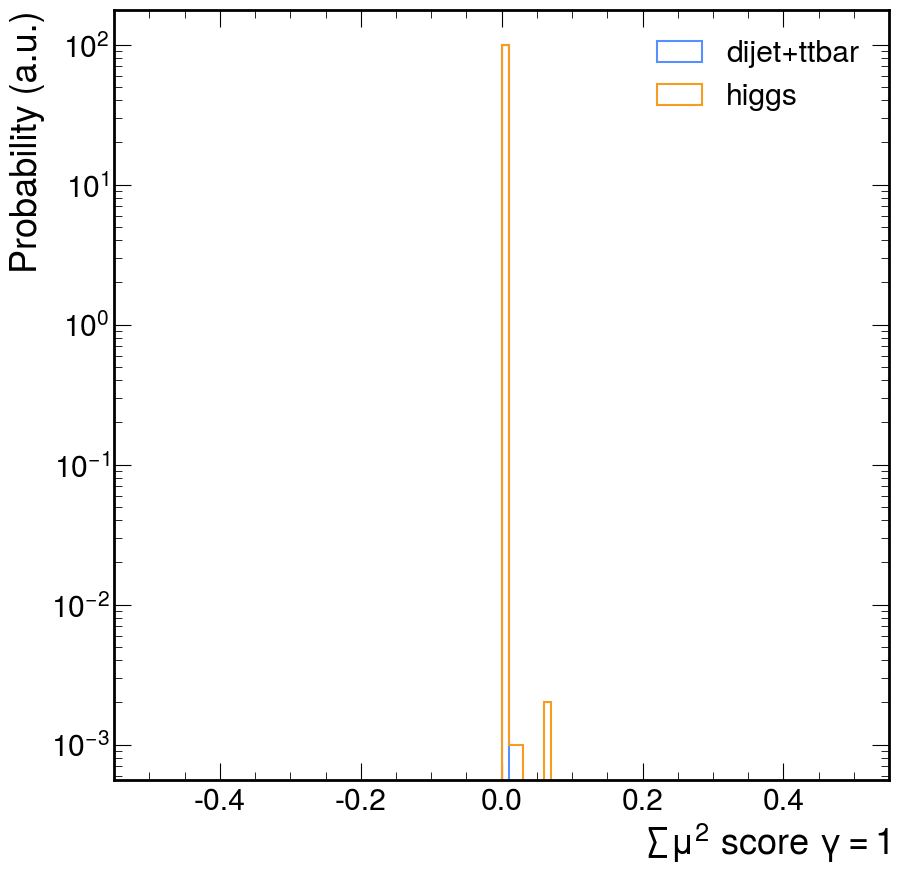

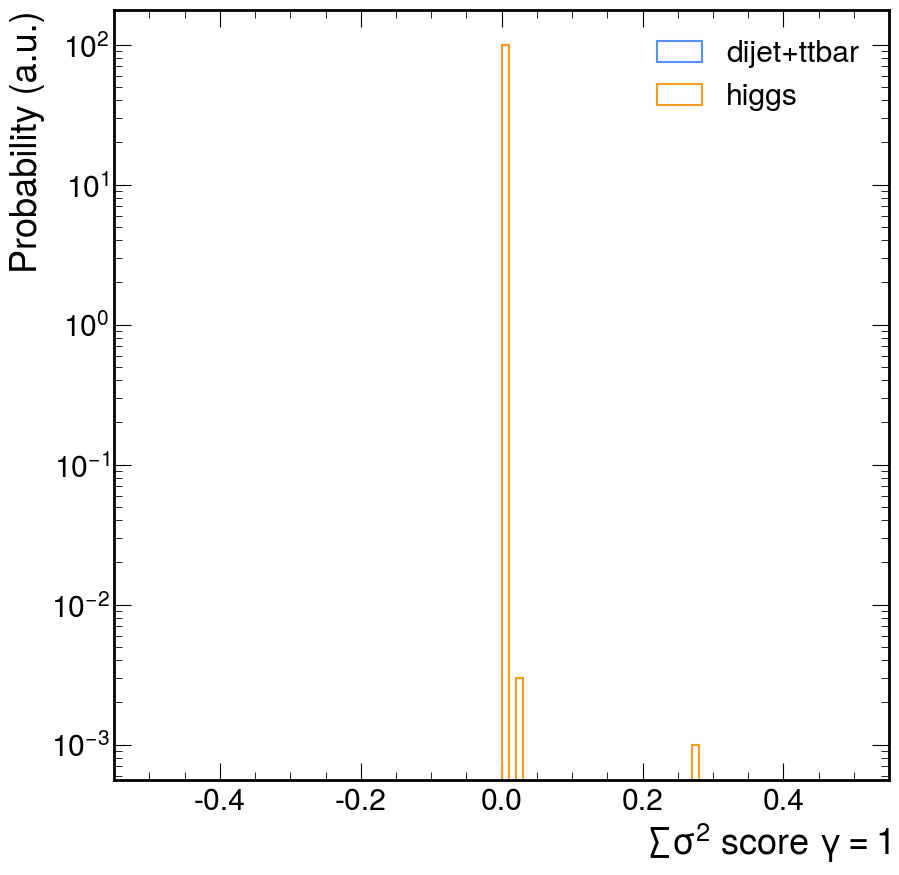

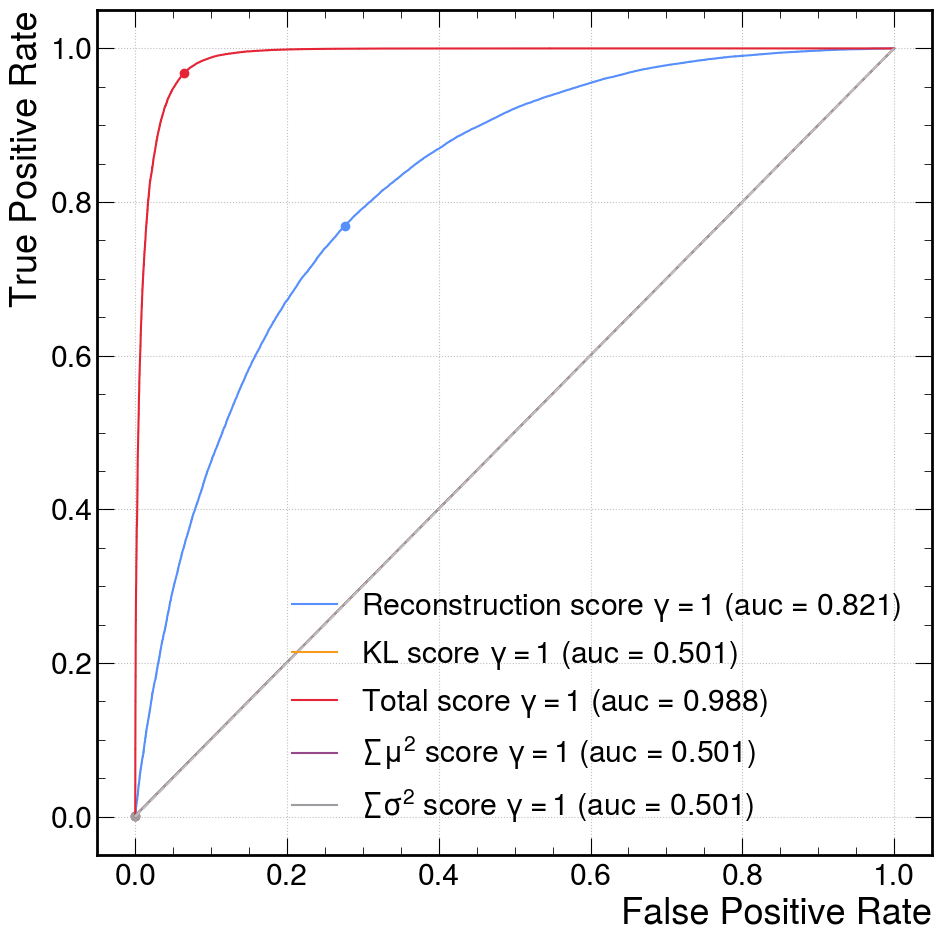

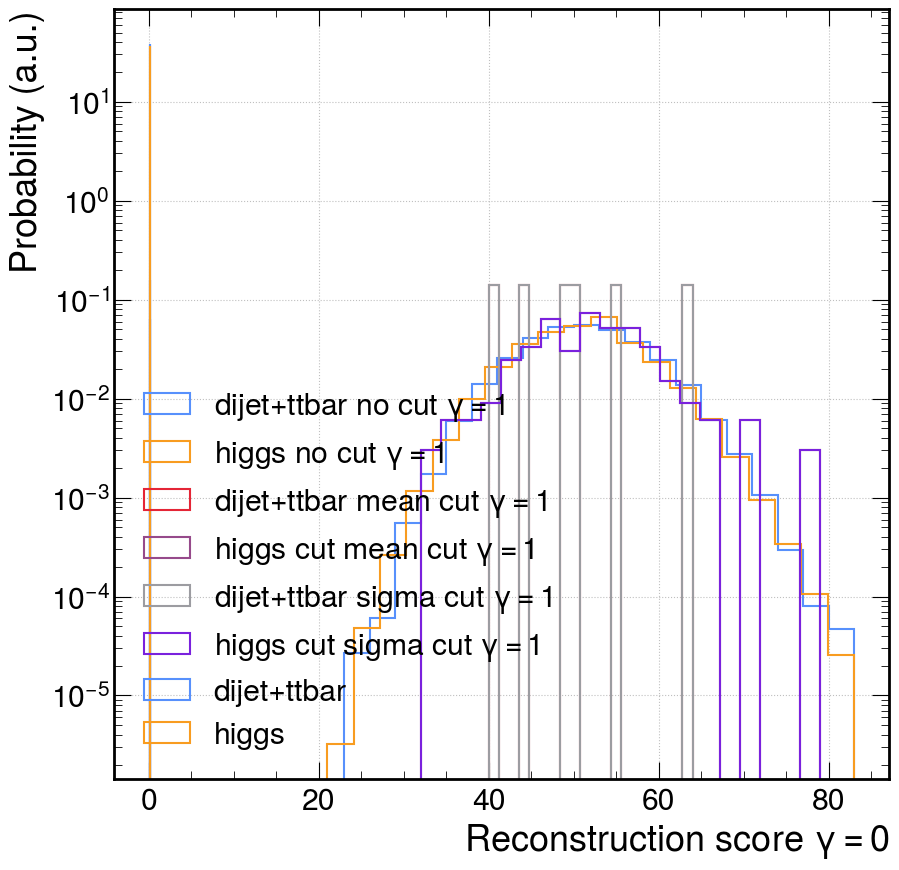

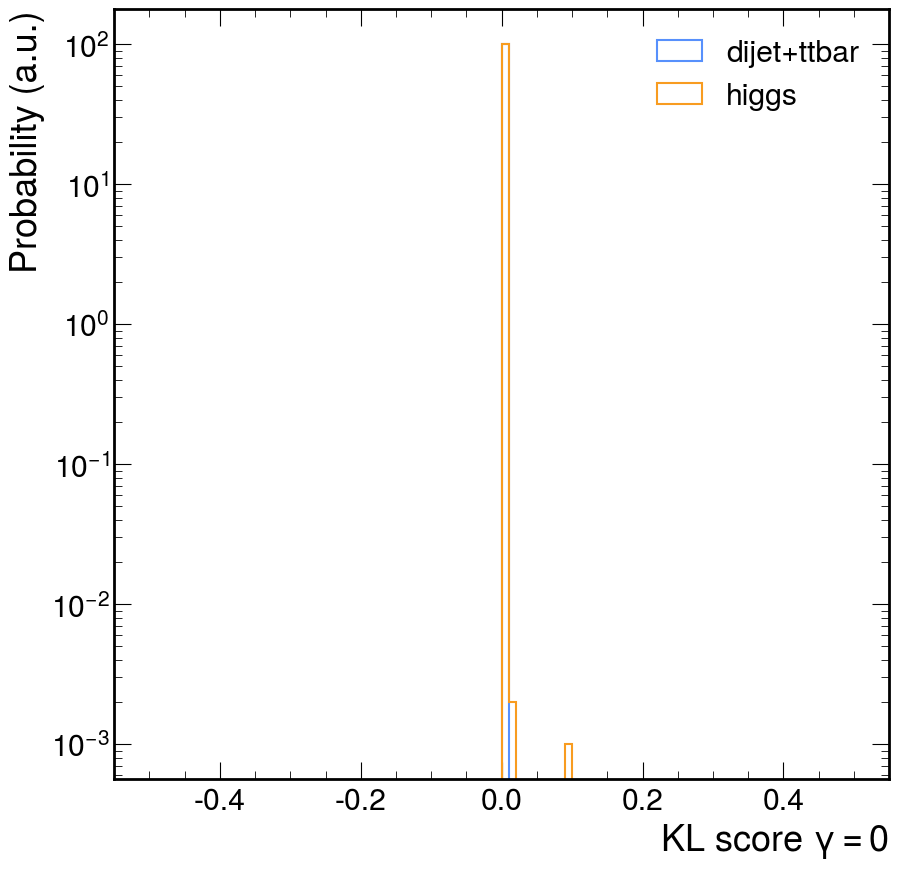

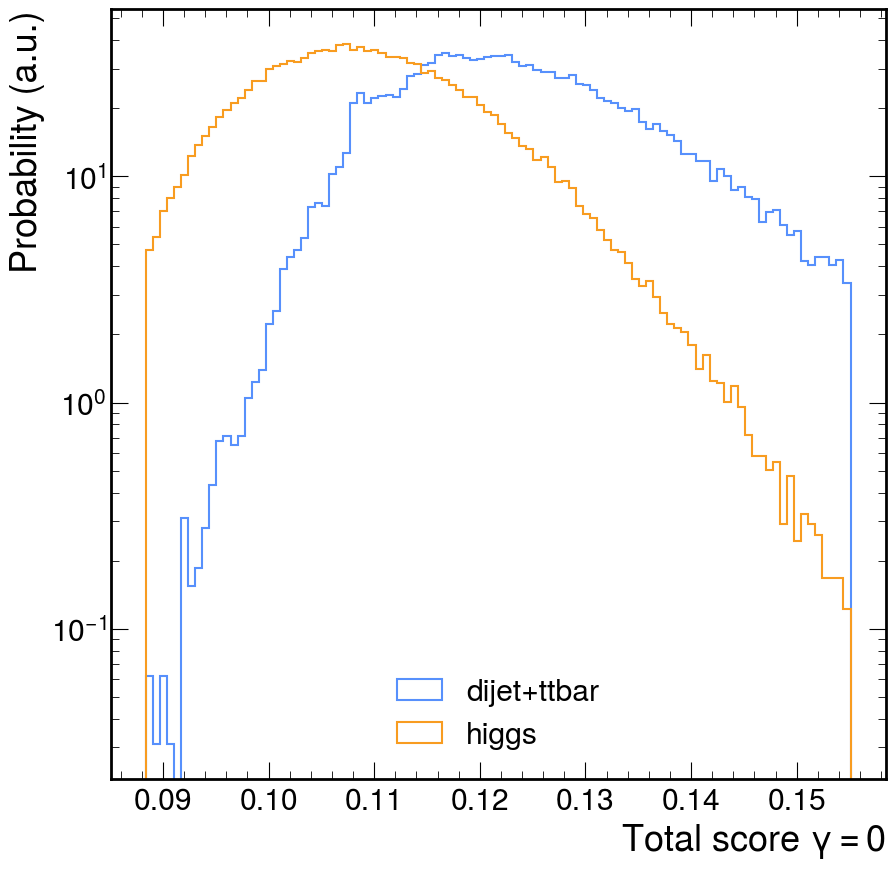

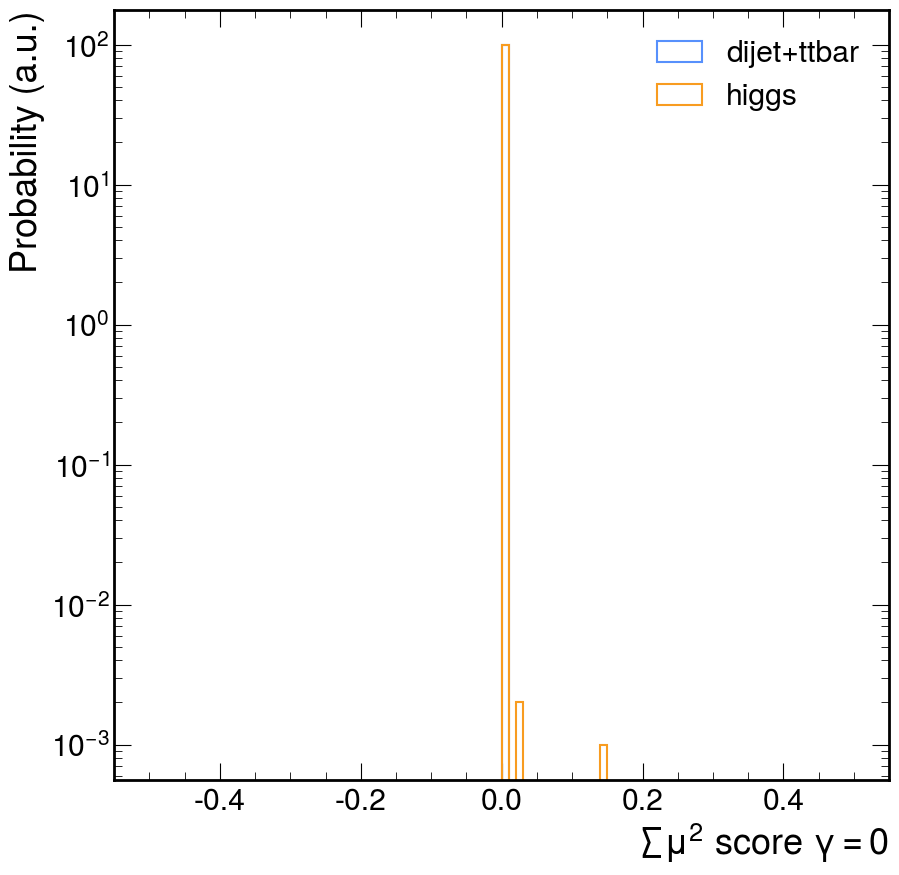

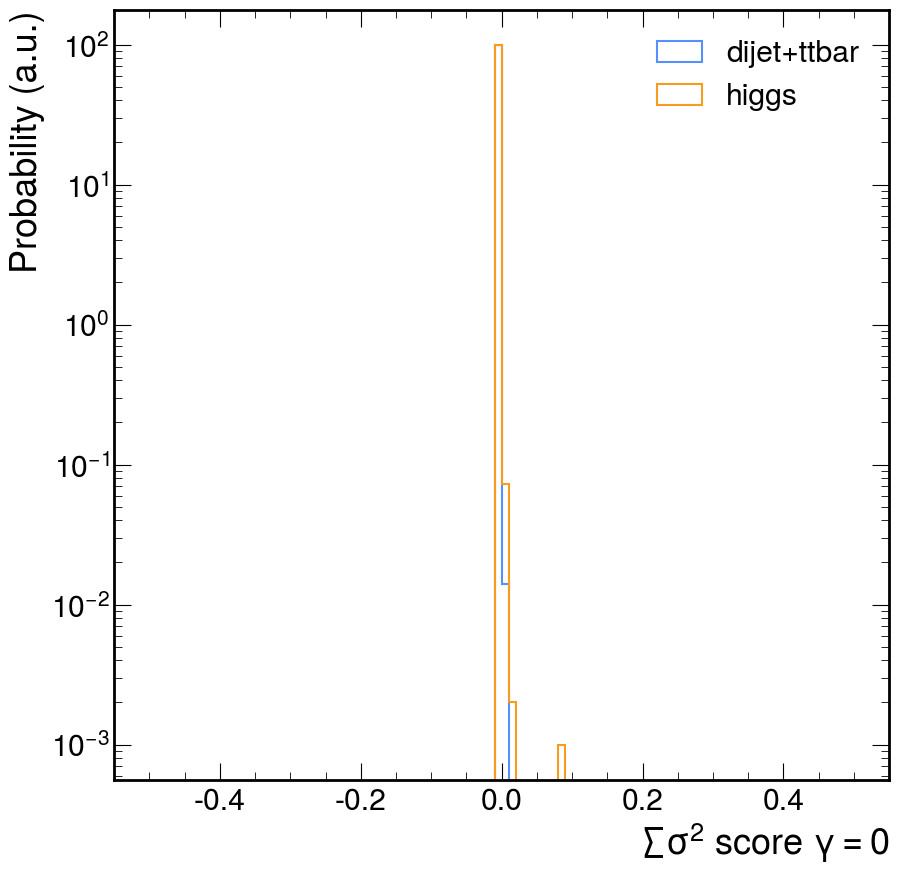

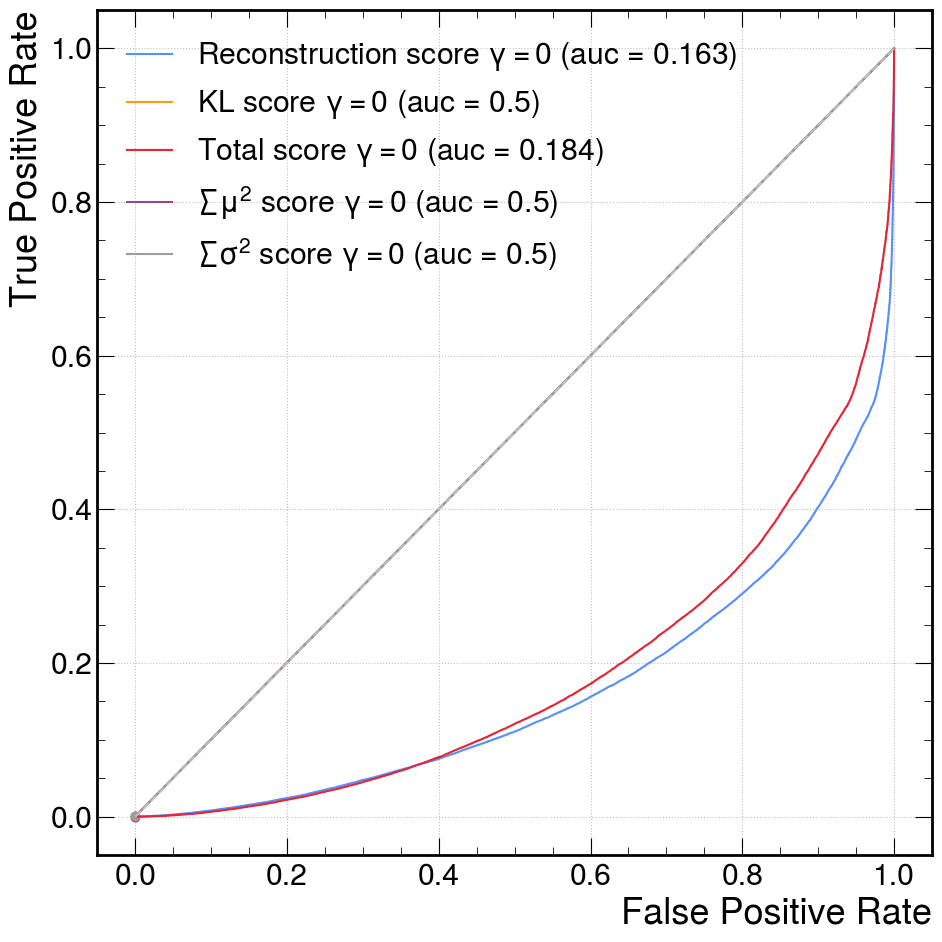

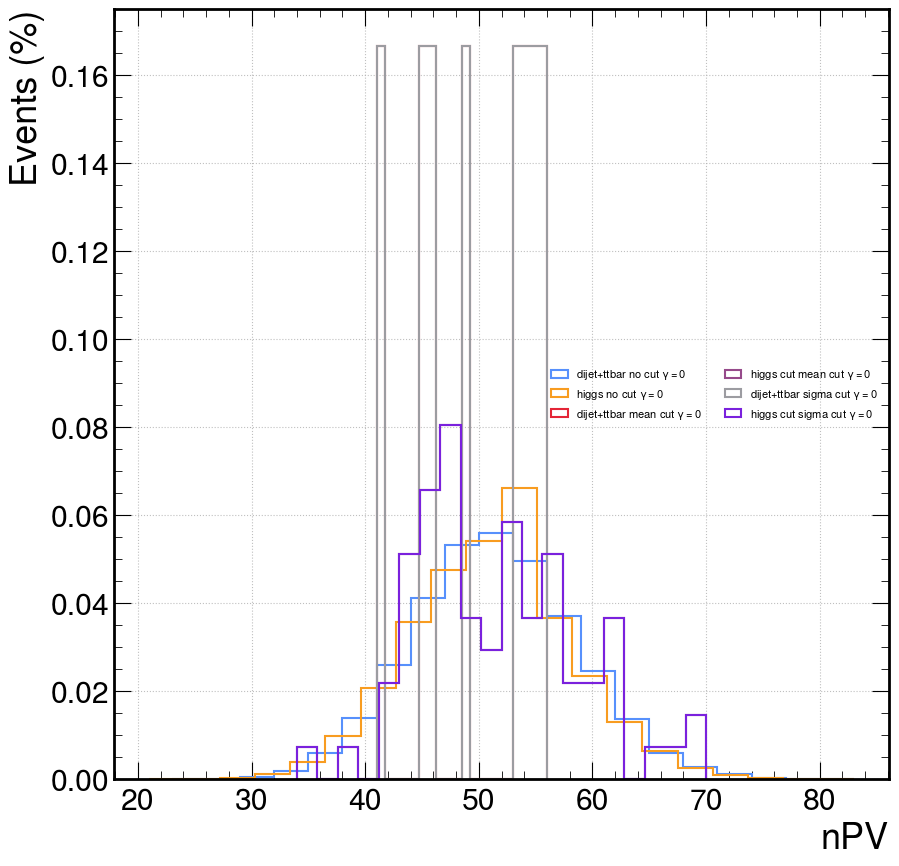

In [6]:
# generate plots for the anomaly scores

def plot_score(normal_score, abnormal_score, bin_size=100, xlabel="Reconstruction Loss", ylabel="Probability (a.u.)"):
    # get range for peak
    combined = np.concatenate([normal_score, abnormal_score])
    lower_bound = np.percentile(combined, 1)
    upper_bound = np.percentile(combined, 99)

    plt.hist(normal_score, bins=bin_size, label="dijet+ttbar", density=True, histtype='step', fill=False, linewidth=1.5, range=(lower_bound, upper_bound))
    plt.hist(abnormal_score, bins=bin_size, label="higgs", density=True, histtype='step', fill=False, linewidth=1.5, range=(lower_bound, upper_bound))
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

def plot_roc(y_test, y_pred, name="Reconstruction"):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr, tpr)

    # find the index of the maximum Youden's J
    youden_j = tpr - fpr
    best_index = np.argmax(youden_j)
    best_threshold = thresholds[best_index]

    plt.scatter(fpr[best_index], tpr[best_index])
    plt.plot(fpr, tpr, "-", label=f"{name} (auc = {round(auc_value, 3)})", linewidth=1.5)
    return best_threshold

def get_plots(model, name=r"$\gamma=0$"):
    # get the different score types
    recon_normal_score = model.score_vector(X_test)[0]
    recon_abnormal_score = model.score_vector(abnormal_data_scaled)[0]

    kl_normal_score = model.score_vector(X_test)[1]
    kl_abnormal_score = model.score_vector(abnormal_data_scaled)[1]

    total_normal_score = model.score_vector(X_test)[2]
    total_abnormal_score = model.score_vector(abnormal_data_scaled)[2]

    mean_normal_score = model.get_mean(X_test).numpy()
    mean_normal_score = np.sum(mean_normal_score**2, axis=1)
    mean_abnormal_score = model.get_mean(abnormal_data_scaled).numpy()
    mean_abnormal_score = np.sum(mean_abnormal_score**2, axis=1)

    sigma_normal_score = model.get_sigma(X_test).numpy()
    sigma_normal_score = np.sum(sigma_normal_score**2, axis=1)
    sigma_abnormal_score = model.get_sigma(abnormal_data_scaled).numpy()
    sigma_abnormal_score = np.sum(sigma_abnormal_score**2, axis=1)

    plot_score(recon_normal_score, recon_abnormal_score, xlabel="Reconstruction score " + name, ylabel="Probability (a.u.)")
    plot_score(kl_normal_score, kl_abnormal_score, xlabel="KL score " + name, ylabel="Probability (a.u.)")
    plot_score(total_normal_score, total_abnormal_score, xlabel="Total score " + name, ylabel="Probability (a.u.)")
    plot_score(mean_normal_score, mean_abnormal_score, xlabel=r"$\sum \mu^2$ score " + name, ylabel="Probability (a.u.)")
    plot_score(sigma_normal_score, sigma_abnormal_score, xlabel=r"$\sum \sigma^2$ score " + name, ylabel="Probability (a.u.)")

    # generate plots for the ROC curves
    thr_recon = plot_roc(y_test, np.concatenate((recon_abnormal_score, recon_normal_score)), name="Reconstruction score " + name)
    thr_kl = plot_roc(y_test, np.concatenate((kl_abnormal_score, kl_normal_score)), name="KL score " + name)
    thr_total = plot_roc(y_test, np.concatenate((total_abnormal_score, total_normal_score)), name="Total score " + name)
    thr_mean = plot_roc(y_test, np.concatenate((mean_abnormal_score, mean_normal_score)), name=r"$\sum \mu^2$ score " + name)
    thr_sigma = plot_roc(y_test, np.concatenate((sigma_abnormal_score, sigma_normal_score)), name=r"$\sum \sigma^2$ score " + name)

    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.show()

    # generate plots for pile-up studies
    bins = 20

    plt.hist(nPV_test, bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="dijet+ttbar no cut " + name)
    plt.hist(nPV_abnormal, bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="higgs no cut " + name)

    # plt.hist(nPV_test[recon_normal_score > thr_recon], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="dijet+ttbar recon cut")
    # plt.hist(nPV_abnormal[recon_abnormal_score > thr_recon], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="higgs cut recon cut")

    # plt.hist(nPV_test[kl_normal_score > thr_kl], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="dijet+ttbar KL cut")
    # plt.hist(nPV_abnormal[kl_abnormal_score > thr_kl], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="higgs cut KL cut")

    # plt.hist(nPV_test[total_normal_score > thr_total], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="dijet+ttbar total cut")
    # plt.hist(nPV_abnormal[total_abnormal_score > thr_total], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="higgs cut total cut")

    plt.hist(nPV_test[mean_normal_score > thr_mean], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="dijet+ttbar mean cut " + name)
    plt.hist(nPV_abnormal[mean_abnormal_score > thr_mean], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="higgs cut mean cut " + name)

    plt.hist(nPV_test[sigma_normal_score > thr_sigma], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="dijet+ttbar sigma cut " + name)
    plt.hist(nPV_abnormal[sigma_abnormal_score > thr_sigma], bins=bins, density=True, histtype='step', fill=False, linewidth=1.5, label="higgs cut sigma cut " + name)

    plt.xlabel("nPV")
    plt.ylabel("Events (%)")

    plt.legend(loc='best', ncol=2, prop={'size': 8})
    plt.grid(True)

get_plots(MiVAE_model, name=r"$\gamma=1$")
get_plots(MiVAE_model_gamma_zero, name=r"$\gamma=0$")
